C:\Users\pmall\AppData\Local\Temp\ipykernel_17452\1832027434.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vote_review_stats = data.groupby('vote_bins').agg(agg_funcs).reset_index()


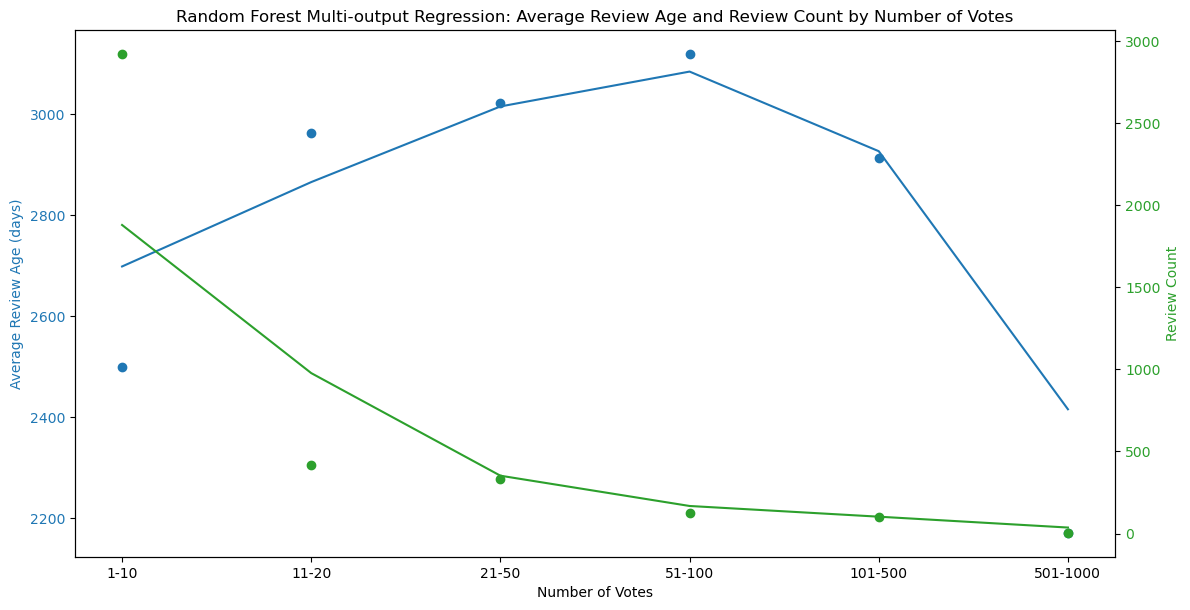

In [1]:
# Multi forest regression including reviews and age in Y-axis and number of votes in x-axis

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import numpy as np

# Load the dataset
data = pd.read_json('C:/USD/ms-aai-501-final-project/data/Software_5-core.json', lines=True)

# Ensure 'vote' is numeric, converting errors to NaN and then dropping these rows
data['vote'] = pd.to_numeric(data['vote'], errors='coerce')
data.dropna(subset=['vote'], inplace=True)

# Convert 'reviewTime' to datetime format
# Double-check this conversion is successful
data['reviewTime'] = pd.to_datetime(data['reviewTime'], errors='coerce')
# Drop any rows that failed to convert
data.dropna(subset=['reviewTime'], inplace=True)

# Calculate the review age in days
latest_date = data['reviewTime'].max()
data['review_age_days'] = (latest_date - data['reviewTime']).dt.days

# Define bins and labels for vote counts
bins = [-1, 0, 10, 20, 50, 100, 500, 1000, np.inf]
bin_labels = ['0', '1-10', '11-20', '21-50', '51-100', '101-500', '501-1000', '1001+']
data['vote_bins'] = pd.cut(data['vote'], bins=bins, labels=bin_labels)

# Group by binned vote counts to calculate both the average review age and total number of reviews per bin
agg_funcs = {'review_age_days': 'mean', 'reviewTime': 'count'}
vote_review_stats = data.groupby('vote_bins').agg(agg_funcs).reset_index()
vote_review_stats.rename(columns={'reviewTime': 'review_count'}, inplace=True)

# Drop rows with NaN values in either target variable
vote_review_stats.dropna(subset=['review_age_days', 'review_count'], inplace=True)

# Ensure 'vote_bins' is treated as categorical data with proper ordering
vote_review_stats['vote_bins'] = pd.Categorical(vote_review_stats['vote_bins'], categories=bin_labels, ordered=True)

# Prepare data for Random Forest Regression
X = vote_review_stats.index.values.reshape(-1, 1)  # Using the index as a simple feature for the model
y = vote_review_stats[['review_age_days', 'review_count']].values  # Two target variables

# Create and fit a multi-output Random Forest regression model
rf_regressor_multi = RandomForestRegressor(n_estimators=100, random_state=0)
rf_regressor_multi.fit(X, y)

# Predict using the model
y_pred_multi = rf_regressor_multi.predict(X)

# Plotting - Dual y-axes for both targets
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Votes')
ax1.set_ylabel('Average Review Age (days)', color=color)
ax1.scatter(vote_review_stats['vote_bins'], vote_review_stats['review_age_days'], color=color)
ax1.plot(vote_review_stats['vote_bins'], y_pred_multi[:, 0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Review Count', color=color)  
ax2.scatter(vote_review_stats['vote_bins'], vote_review_stats['review_count'], color=color)
ax2.plot(vote_review_stats['vote_bins'], y_pred_multi[:, 1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Random Forest Multi-output Regression: Average Review Age and Review Count by Number of Votes')
plt.show()